In [2]:
from pathlib import Path
from os import path
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
from itertools import combinations
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

In [3]:
###
# Paths
###

base_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
config_path = Path(path.abspath("")).parent.joinpath("config_mni.yml")

###
# Import data
###

data_path = base_path.joinpath("MatlabFile.mat")
data = loadmat(data_path)
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

###
# Convert data to Dataframe
###

ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = data["SamplingFrequency"][0][0]
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)
df_info["region"] = df_info["region"].apply(lambda x: regions_map[x])

###
# Loop through patients to compute measures
###

pats = df_info["pat"].unique().tolist()

Test computations with some test data

In [4]:
df_info_test = df_info[df_info["pat"] == pats[5]].reset_index(drop=True)
data_test = data_W[df_info.index[df_info["pat"] == pats[5]]]
data_test.shape

(14, 13600)

In [5]:
df_info_test.head()

,pat,chan,type,region,mni_x,mni_y,mni_z
0,6,GD006Rs4,D,Central operculum,49.0,-1.0,6.0
1,6,GD006Rs5,D,Central operculum,53.0,-1.0,7.0
2,6,GD006Rs6,D,Central operculum,57.0,-1.0,6.0
3,6,GD006Rq3,D,Frontal operculum,40.0,24.0,4.0
4,6,GD006Rq4,D,Frontal operculum,43.0,24.0,4.0


In [54]:
n_chs = data_test.shape[0]
data_test_edges = np.empty((n_chs * (n_chs - 1) // 2, data_test.shape[1]))
df_info_test_edges = pd.DataFrame(columns=["chan1", "chan2"])

In [55]:
data_test_edges.shape

(91, 13600)

In [56]:
# compute all pairs of channels
idx_nan = np.where(data_test[0] == 0)[0]
for i, (ch1, ch2) in enumerate(combinations(df_info_test["chan"], 2)):
    idx1 = df_info_test.index[df_info_test["chan"] == ch1].values[0]
    idx2 = df_info_test.index[df_info_test["chan"] == ch2].values[0]
    data_edge = zscore(data_test[idx1]) * zscore(data_test[idx2])
    # data_edge[idx_nan] = np.nan
    data_test_edges[i] = data_edge

    df_info_test_edges.loc[i] = [ch1, ch2]

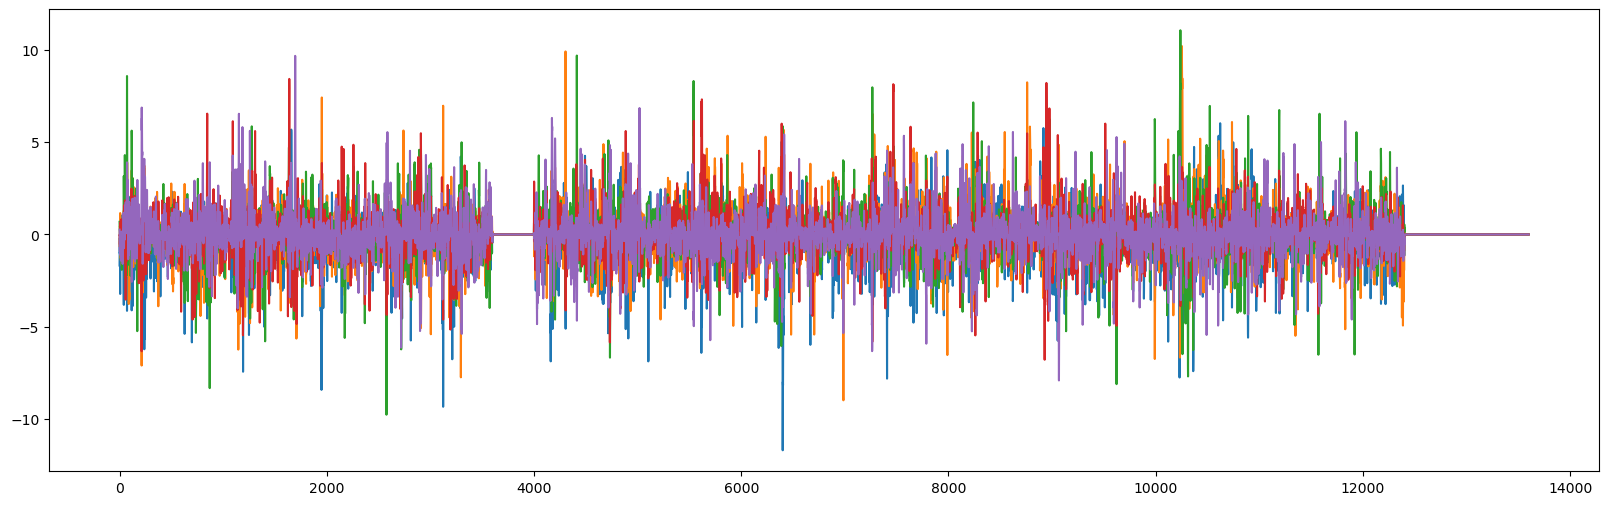

In [57]:
plt.figure(figsize=[20,6])
plt.plot(data_test_edges[:5].T)
plt.show()

In [58]:
acfs = [acf(data, adjusted=True, nlags=100, missing="drop") for data in data_test_edges]

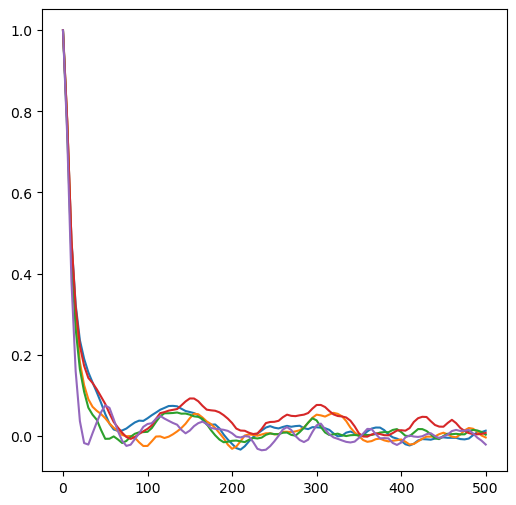

In [59]:
plt.figure(figsize=[6,6])
for acf_ in acfs[15:20]:
    plt.plot(np.linspace(0, 500, len(acf_)), acf_)
plt.show()

AMI

In [13]:
from automutualinformation import sequential_mutual_information as smi

In [60]:
# digitize signal into discrete states
data_test_edges_dig = np.empty_like(data_test_edges)
nbins = 64 # how many bins to compute over
for i, dat in enumerate(data_test_edges):
    bins =  np.linspace(np.nanmin(dat), np.nanmax(dat), nbins)
    data_test_edges_dig[i] = np.digitize(dat, bins, right=True)
    data_test_edges_dig[i][np.isnan(dat)] = np.nan

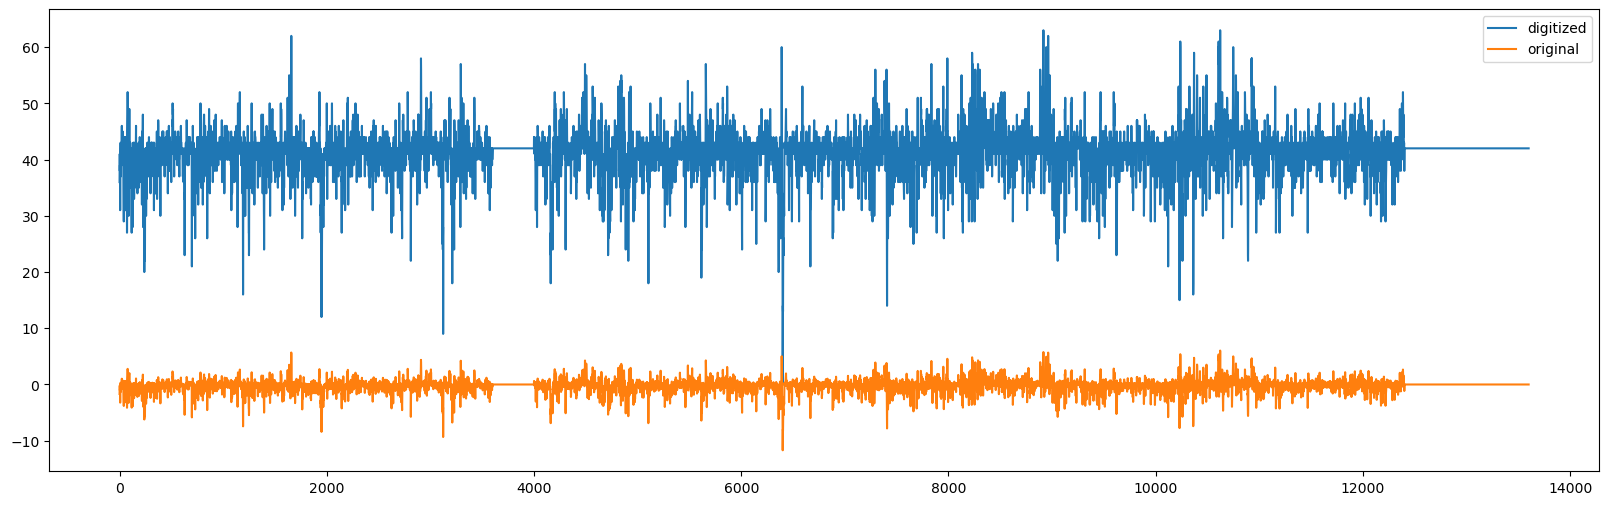

In [61]:
plt.figure(figsize=[20,6])
plt.plot(data_test_edges_dig[0], label="digitized")
plt.plot(data_test_edges[0], label="original")
# plt.xlim(0, 1000)
plt.legend()
plt.show()

In [62]:
lags = np.arange(1, 101)
(MI, _), (shuff_MI, _) = smi(
    [data_test_edges_dig[0]], distances=lags, n_jobs=1
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'MI')

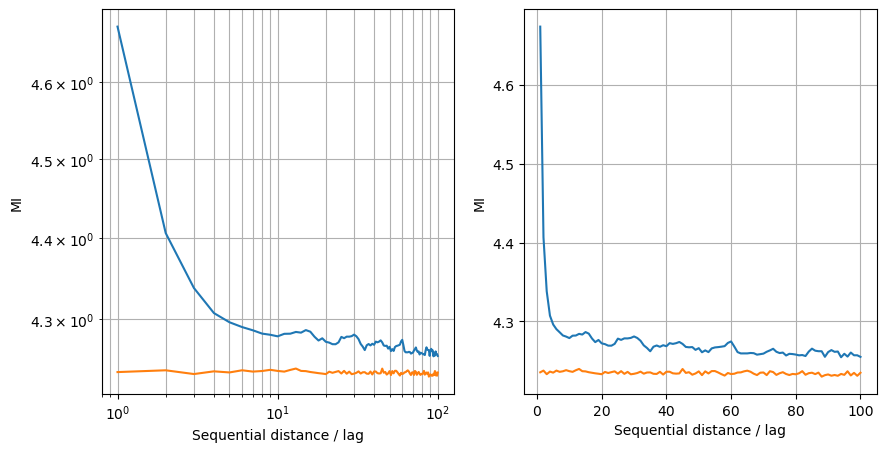

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(lags, MI)
ax.plot(lags, shuff_MI)
ax.grid(which='both')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag', fontsize=10)
ax.set_ylabel('MI', fontsize=10)

ax = axs[1]
ax.plot(lags, MI)
ax.plot(lags, shuff_MI)
ax.grid(which='both')
ax.set_xlabel('Sequential distance / lag', fontsize=10)
ax.set_ylabel('MI', fontsize=10)

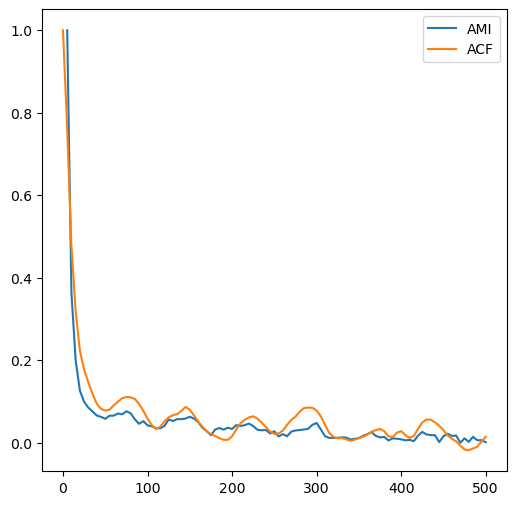

In [64]:
plt.figure(figsize=[6, 6])
plt.plot(lags * 5, (MI - MI.min())/(MI[0] - MI.min()), label="AMI")
plt.plot(np.linspace(0, 500, len(acfs[0])), acfs[0], label="ACF")
plt.legend()
plt.show()

AMI seems more "insensitive" to oscillatory behavior. Is it true also for nodal time series?

In [65]:
acf_data_test = [acf(data, adjusted=True, nlags=100, missing="drop") for data in data_test]

In [69]:
data_test_dig = np.empty_like(data_test)
nbins = 64 # how many bins to compute over
for i, dat in enumerate(data_test):
    bins =  np.linspace(np.nanmin(dat), np.nanmax(dat), nbins)
    data_test_dig[i] = np.digitize(dat, bins, right=True)
    data_test_dig[i][np.isnan(dat)] = np.nan

lags = np.arange(1, 101)
(MI, _), (shuff_MI, _) = smi(
    [data_test_dig[-1]], distances=lags, n_jobs=1
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

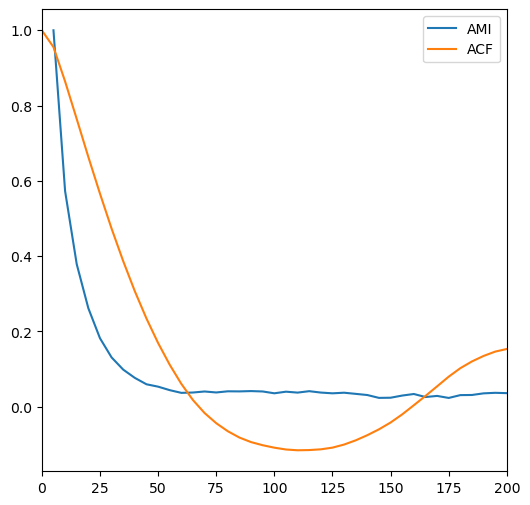

In [70]:
plt.figure(figsize=[6, 6])
plt.plot(lags * 5, (MI - MI.min())/(MI[0] - MI.min()), label="AMI")
plt.plot(np.linspace(0, 500, len(acf_data_test[-1])), acf_data_test[-1], label="ACF")
plt.xlim(0, 200)
plt.legend()
plt.show()